# Импорт, преобразование данных и предварительный анализ

In [127]:
import pandas as pd
import matplotlib.pyplot as plt

In [177]:
prod = pd.read_csv('data/18. Monthly production of clay bricks million units Jan 1956  Aug 1995.csv', index_col=0, parse_dates=True)

In [178]:
prod.head(5)

,x
1956-01-01,53
1956-02-01,68
1956-03-01,68
1956-04-01,66
1956-05-01,72


Изменю название анализируемого столбца временного ряда.

In [179]:
prod.columns = ['million_units']

In [180]:
prod.head(5)

,million_units
1956-01-01,53
1956-02-01,68
1956-03-01,68
1956-04-01,66
1956-05-01,72


Посмотрим на тип данных колонки million_units - с ним все хорошо, никаких преобразований делать не нужно.

In [181]:
prod.dtypes

million_units    int64
dtype: object

Посмотрим на график временного ряда.

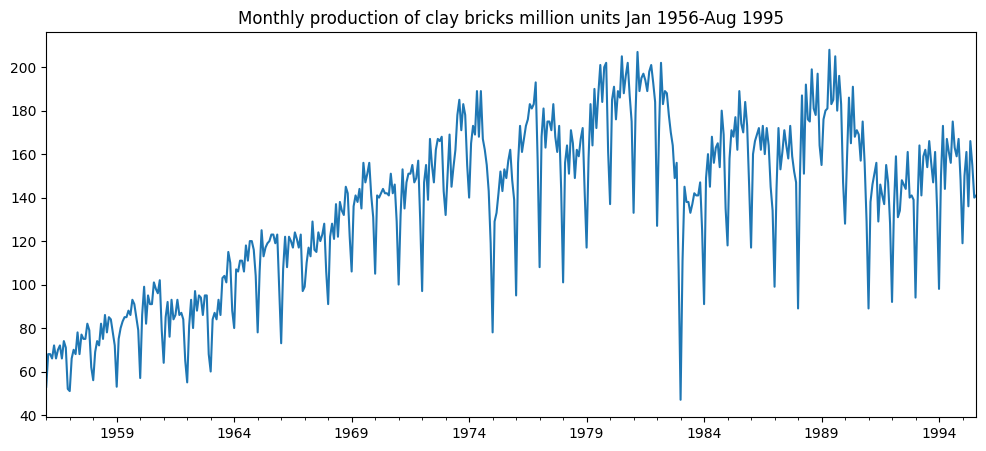

In [182]:
prod['million_units'].plot(figsize=(12,5))
plt.title('Monthly production of clay bricks million units Jan 1956-Aug 1995')
plt.show()

Чтобы определить, присутствует ли в модели тренд и сезонность, построю коррелограмму.

In [183]:
from statsmodels.graphics.tsaplots import plot_acf

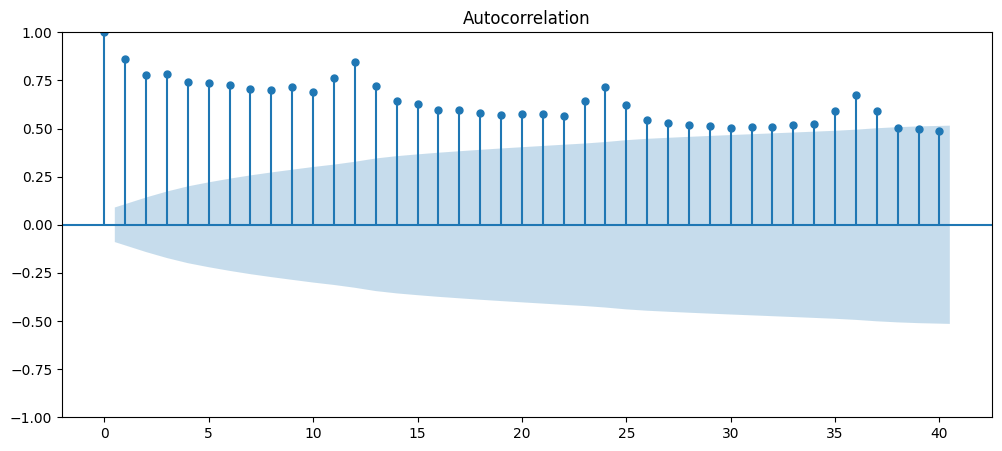

In [184]:
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(prod['million_units'], lags=40, ax=ax)
plt.show()

### Видно, что присутствует тренд, а также сезонность - 12 месяцев, т.к. корреляция самая высокая в точках лагов, кратных 12 => нужно использовать модель Хольта-Уинтерса.

# Построение модели Хольта-Уинтерса и прогноза на 10 лет

## 1. Возьмем весь исходный ряд

In [185]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
from statsmodels.tools.eval_measures import mse

Поставим аддитивный тренд и мультипликативную сезонность, исходя из графика

In [186]:
model_1 = ExponentialSmoothing(prod['million_units'], trend='add', damped_trend=True, seasonal_periods=12, seasonal='mul', initialization_method='estimated')

c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [187]:
fitted_model_1 = model_1.fit()

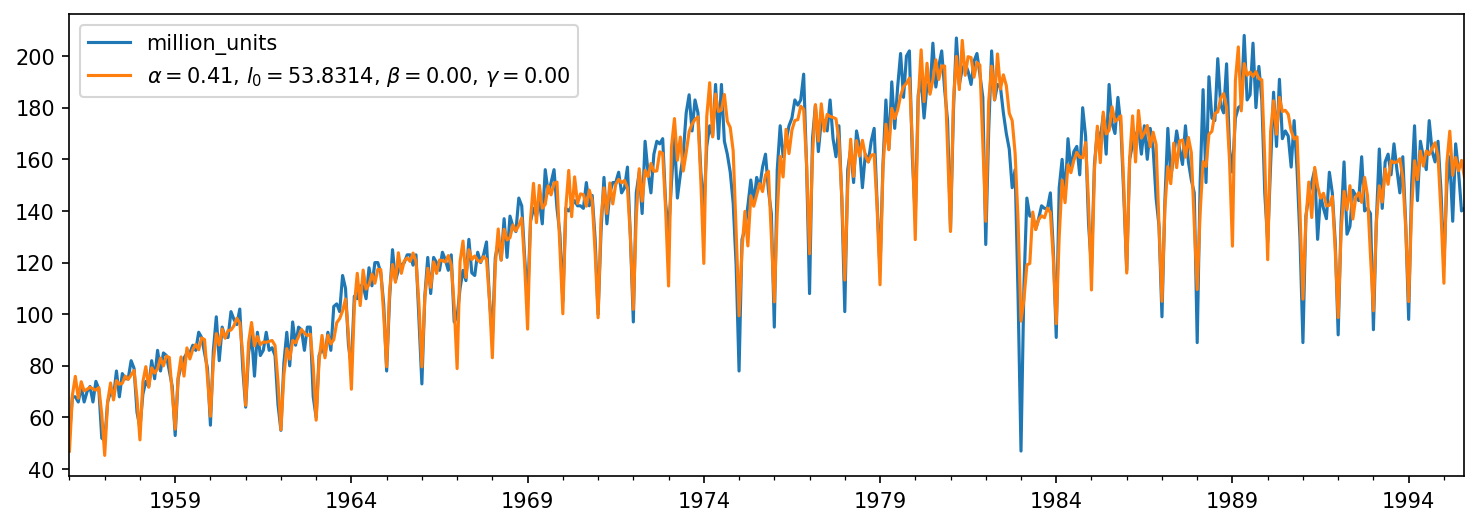

In [188]:
plt.figure(figsize=(12, 4), dpi=150)
prod['million_units'].plot(legend=True)
fitted_model_1.fittedvalues.rename(r'$\alpha=%.2f$' % fitted_model_1.model.params['smoothing_level'] + ', ' +
                        r'$l_0=%.4f$' % fitted_model_1.model.params['initial_level'] + ', ' +
                        r'$\beta=%.2f$' % fitted_model_1.model.params['smoothing_trend'] + ', ' +
                        r'$\gamma=%.2f$' % fitted_model_1.model.params['smoothing_seasonal']).plot(legend=True)
plt.show()

In [189]:
mse1 = mse(prod['million_units'], fitted_model_1.fittedvalues)
mse1

80.38833926249816

Видим, что среднеквадратическая ошибка мала, значит, модель довольно хорошо аппроксимирует исходный временной ряд

Построим прогноз

In [190]:
start = prod.index[-1]
end = start + pd.DateOffset(months=124)
start, end

(Timestamp('1995-08-01 00:00:00'), Timestamp('2005-12-01 00:00:00'))

In [191]:
forecast_1 = fitted_model_1.predict(start=start, end=end)

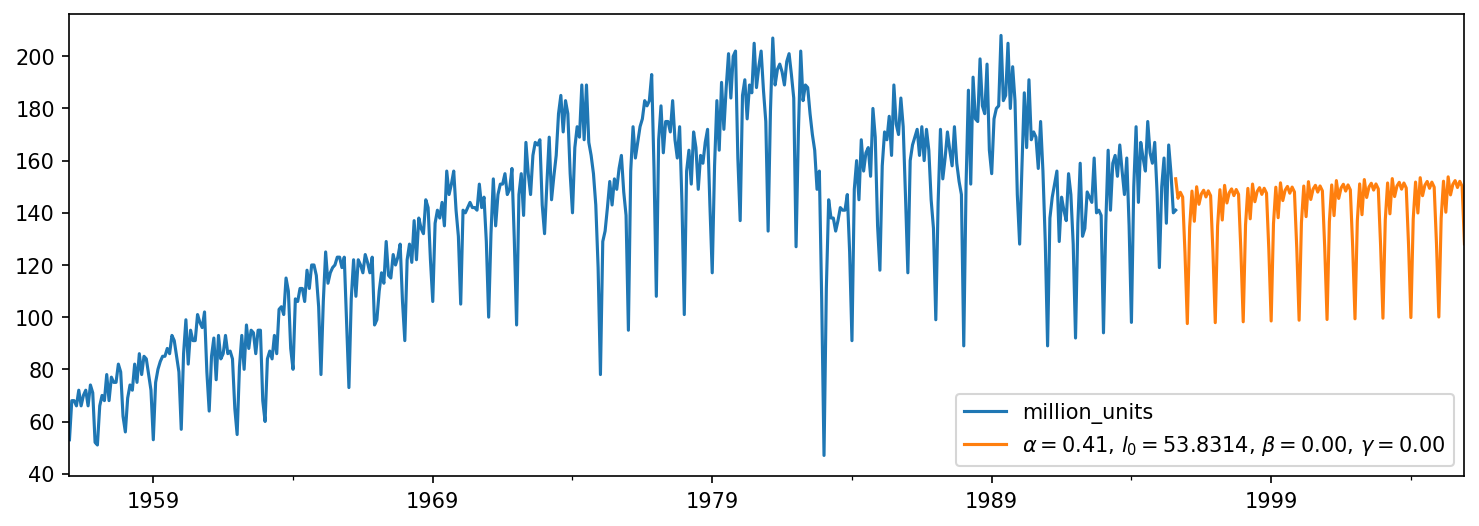

In [192]:
plt.figure(figsize=(12,4), dpi=150)
prod['million_units'].plot(legend=True)
forecast_1.rename(r'$\alpha=%.2f$' % fitted_model_1.model.params['smoothing_level'] + ', ' +
                r'$l_0=%.4f$' % fitted_model_1.model.params['initial_level'] + ', ' +
                r'$\beta=%.2f$' % fitted_model_1.model.params['smoothing_trend'] + ', ' +
                r'$\gamma=%.2f$' % fitted_model_1.model.params['smoothing_seasonal']).plot(legend=True)
plt.show()

А если взять данные с 1975 года?

## 2. Возьмем данные с 1975 года

Видно, что в районе 1975 года ситуация поменялась и кирпичи начали производиться исходя из других данных, т.е. все данные до 1975 года устарели, возможно, потому что началось введение и распространение других материалов для построения домов, изменился спрос на приобретение кирпичей, упала рождаемость/экономика страны и т.д.

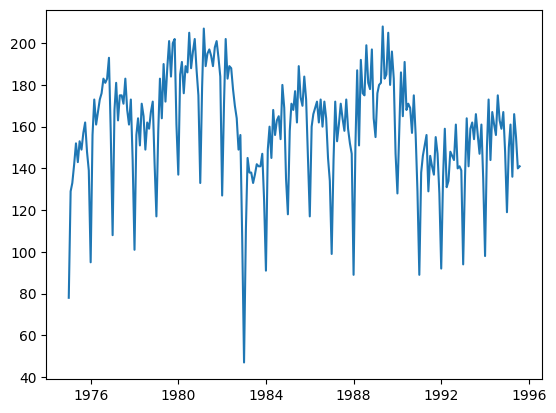

In [193]:
plt.plot(prod['1975-01-01'::]['million_units'])

По графику видно, что в оставшейся части присутствует аддитивная сезонность в размере 8 лет=12*8 месяцев

In [194]:
model_2 = ExponentialSmoothing(prod['1975-01-01'::]['million_units'], seasonal_periods=12*8, seasonal='add', initialization_method='estimated')

c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [195]:
fitted_model_2 = model_2.fit()

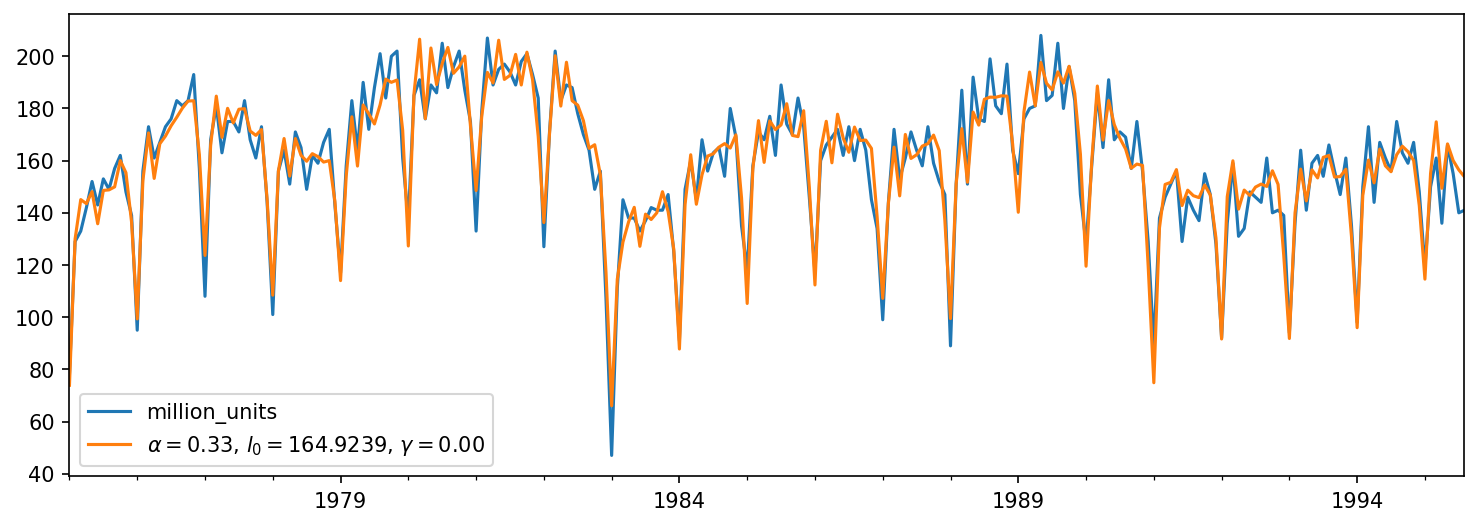

In [196]:
plt.figure(figsize=(12, 4), dpi=150)
prod['1975-01-01'::]['million_units'].plot(legend=True)
fitted_model_2.fittedvalues.rename(r'$\alpha=%.2f$' % fitted_model_2.model.params['smoothing_level'] + ', ' +
                                r'$l_0=%.4f$' % fitted_model_2.model.params['initial_level'] + ', ' +
                                r'$\gamma=%.2f$' % fitted_model_2.model.params['smoothing_seasonal']).plot(legend=True)
plt.show()

In [198]:
mse2 = mse(prod['1975-01-01'::]['million_units'], fitted_model_2.fittedvalues)
mse2

64.0574892742743

Ошибка еще меньше чем была, значит, решение отбросить начальные данные - целесообразно

Построим прогноз

In [199]:
start = prod.index[-1]
end = start + pd.DateOffset(months=124)
start, end

(Timestamp('1995-08-01 00:00:00'), Timestamp('2005-12-01 00:00:00'))

In [201]:
forecast_2 = fitted_model_2.predict(start=start, end=end)

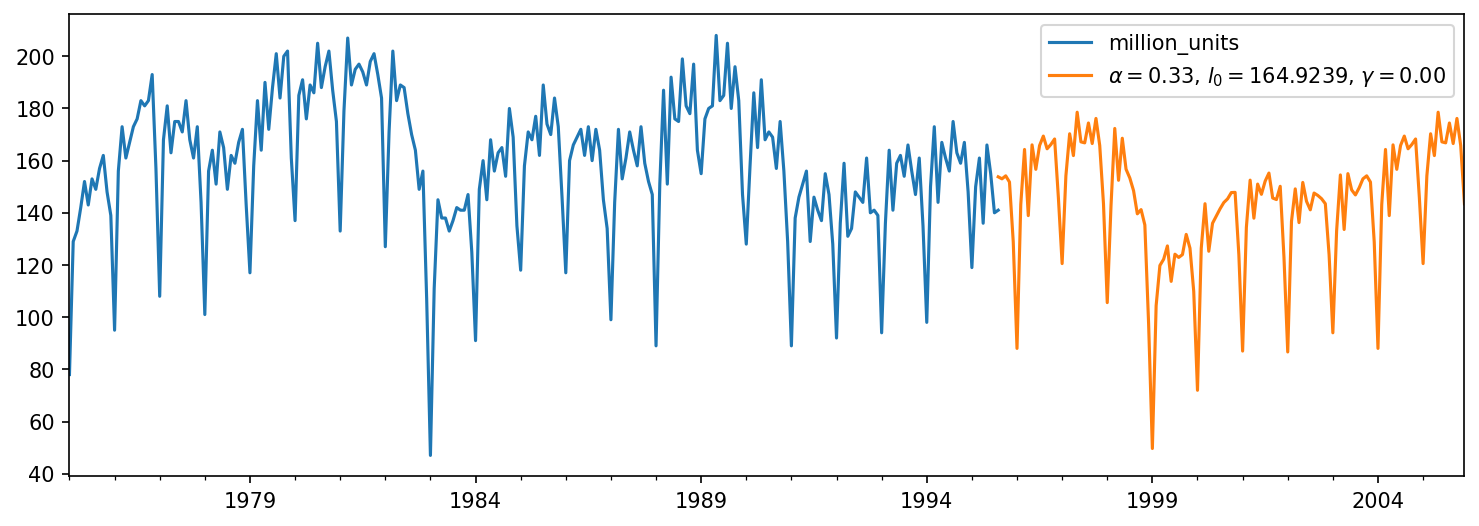

In [202]:
plt.figure(figsize=(12,4), dpi=150)
prod['1975-01-01'::]['million_units'].plot(legend=True)
forecast_2.rename(r'$\alpha=%.2f$' % fitted_model_2.model.params['smoothing_level'] + ', ' +
                r'$l_0=%.4f$' % fitted_model_2.model.params['initial_level'] + ', ' +
                r'$\gamma=%.2f$' % fitted_model_2.model.params['smoothing_seasonal']).plot(legend=True)
plt.show()

Наложим графики друг на друга

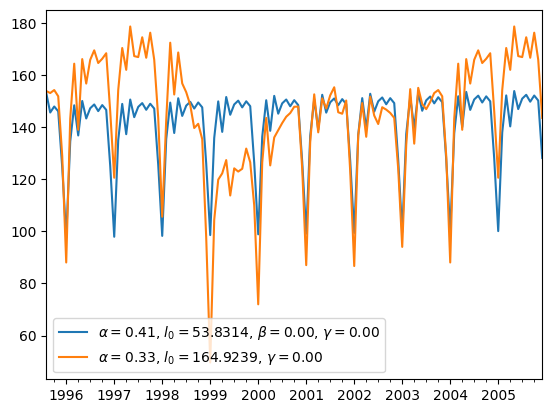

In [203]:
forecast_1.rename(r'$\alpha=%.2f$' % fitted_model_1.model.params['smoothing_level'] + ', ' +
                r'$l_0=%.4f$' % fitted_model_1.model.params['initial_level'] + ', ' +
                r'$\beta=%.2f$' % fitted_model_1.model.params['smoothing_trend'] + ', ' +
                r'$\gamma=%.2f$' % fitted_model_1.model.params['smoothing_seasonal']).plot(legend=True)
forecast_2.rename(r'$\alpha=%.2f$' % fitted_model_2.model.params['smoothing_level'] + ', ' +
                r'$l_0=%.4f$' % fitted_model_2.model.params['initial_level'] + ', ' +
                r'$\gamma=%.2f$' % fitted_model_2.model.params['smoothing_seasonal']).plot(legend=True)
plt.show()

Все-таки прогноз с "горбами" лучше описывает дальнейшее поведение временного ряда на основе последних данных, нежели прогноз по всему временному ряду

## 3. Попробуем достроить временной ряд

In [204]:
prod.tail(5) # тут видно, что данные на последний год не до декабря,а до августа

,million_units
1995-04-01,136
1995-05-01,166
1995-06-01,155
1995-07-01,140
1995-08-01,141


Достроим временной ряд до 1995-12-01, используя наивную модель

In [206]:
naive_forecast = pd.concat([prod['1987-09-01':'1987-12-01':]])
naive_forecast.index = pd.date_range('1995-09-01','1995-12-01',freq='MS')

In [207]:
prod_naive_forecast = prod.append(naive_forecast)

C:\Users\Valeria\AppData\Local\Temp\ipykernel_10424\3985261467.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prod_naive_forecast = prod.append(naive_forecast)


<AxesSubplot: >

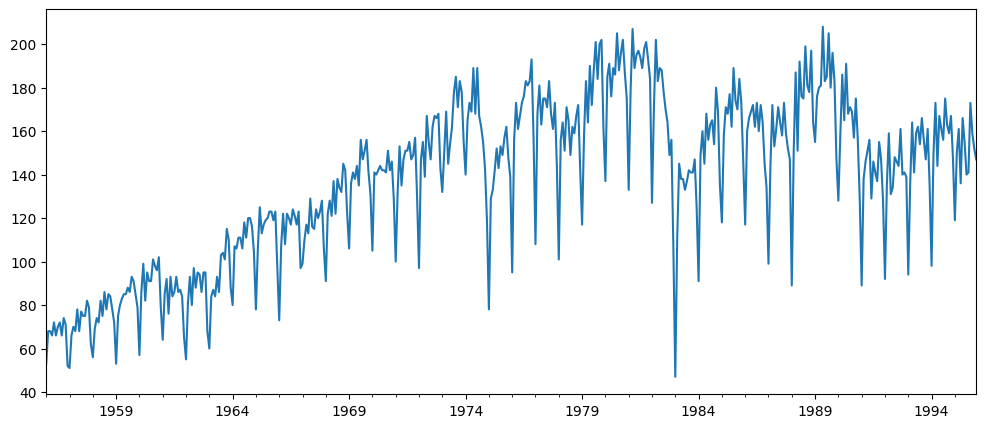

In [208]:
prod_naive_forecast['million_units'].plot(figsize=(12,5))

Построим модель Хольта-Уинтерса уже для достроенного временного ряда

In [163]:
model_3 = ExponentialSmoothing(prod_naive_forecast['1975-01-01'::]['million_units'], seasonal_periods=12*8, seasonal='add', initialization_method='estimated')

c:\users\valeria\pycharmprojects\analysis_and_forecasting\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [209]:
fitted_model_3 = model_3.fit()

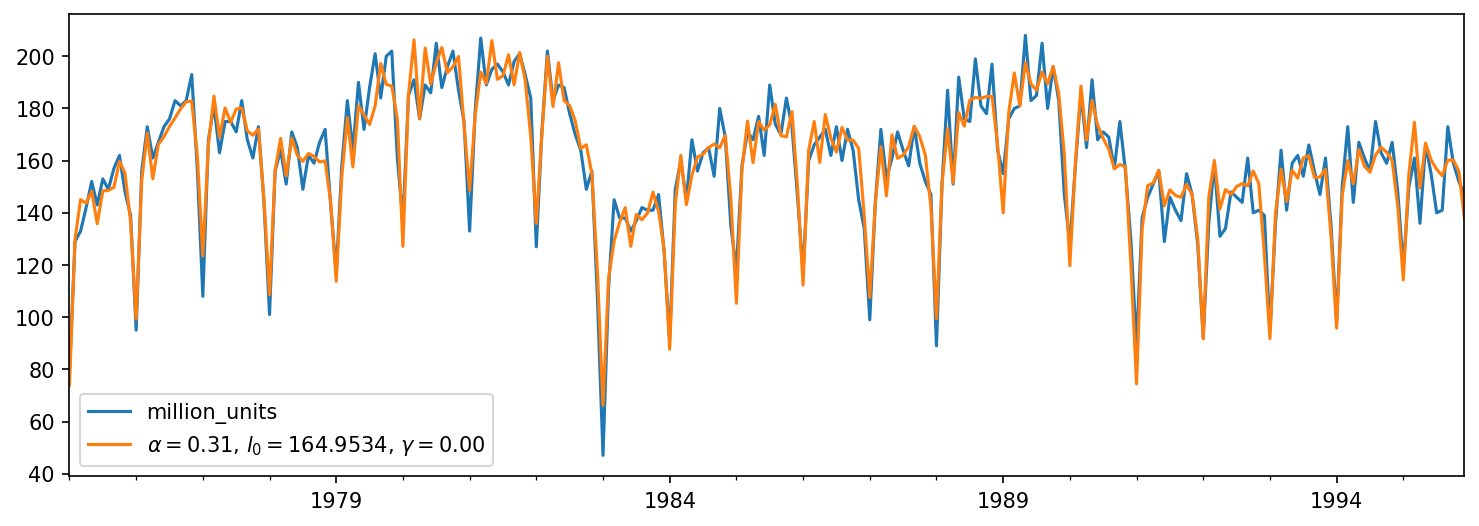

In [210]:
plt.figure(figsize=(12, 4), dpi=150)
prod_naive_forecast['1975-01-01'::]['million_units'].plot(legend=True)
fitted_model_3.fittedvalues.rename(r'$\alpha=%.2f$' % fitted_model_3.model.params['smoothing_level'] + ', ' +
                                r'$l_0=%.4f$' % fitted_model_3.model.params['initial_level'] + ', ' +
                                r'$\gamma=%.2f$' % fitted_model_3.model.params['smoothing_seasonal']).plot(legend=True)
plt.show()

In [212]:
mse3 = mse(fitted_model_3.fittedvalues, prod_naive_forecast['1975-01-01'::]['million_units'])
mse3

64.66861187114002

Ошибка не уменьшилась, но близка к ошибке во 2 модели

Посмотрим на прогноз

In [213]:
start = prod_naive_forecast.index[-1]
end = start + pd.DateOffset(months=124)
start, end

(Timestamp('1995-12-01 00:00:00'), Timestamp('2006-04-01 00:00:00'))

In [214]:
forecast_3 = fitted_model_3.predict(start=start, end=end)

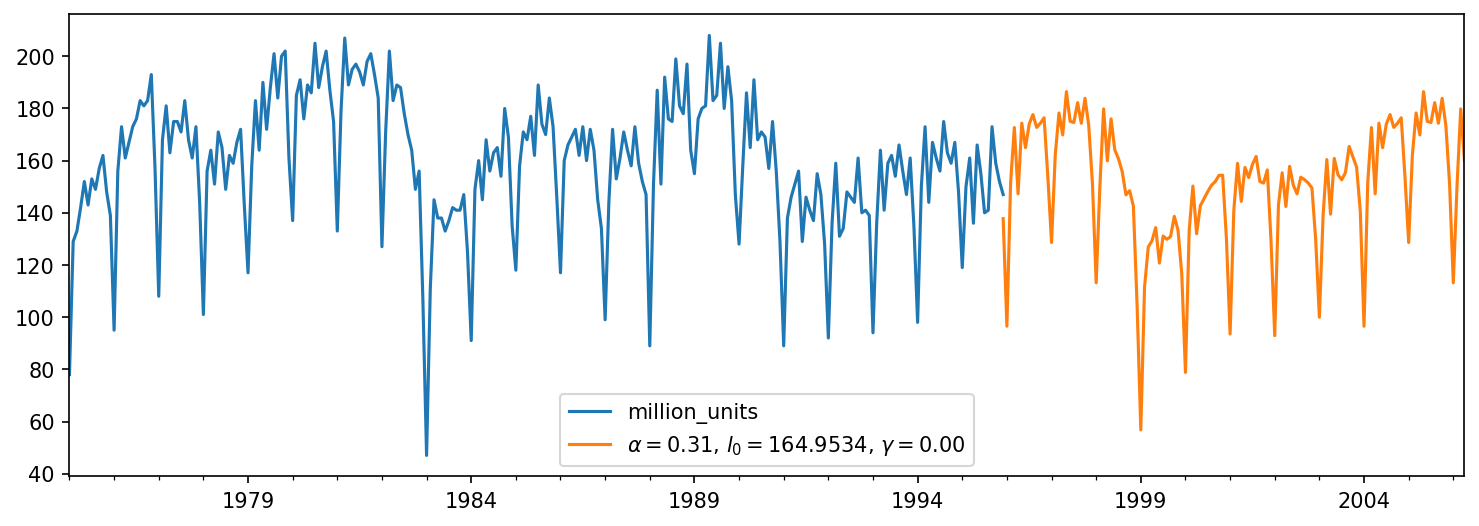

In [215]:
plt.figure(figsize=(12,4), dpi=150)
prod_naive_forecast['1975-01-01'::]['million_units'].plot(legend=True)
forecast_3.rename(r'$\alpha=%.2f$' % fitted_model_3.model.params['smoothing_level'] + ', ' +
                r'$l_0=%.4f$' % fitted_model_3.model.params['initial_level'] + ', ' +
                r'$\gamma=%.2f$' % fitted_model_3.model.params['smoothing_seasonal']).plot(legend=True)
plt.show()

**Прорисуем все получившиеся прогнозы на графике**

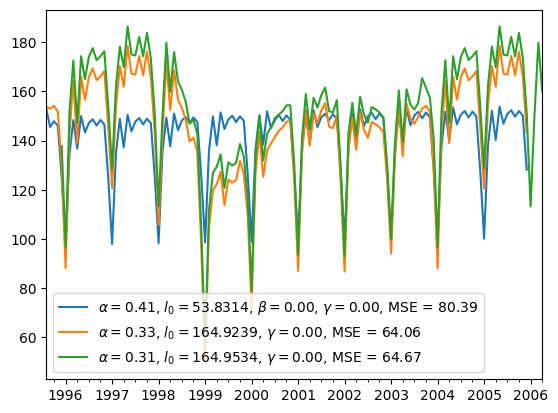

In [216]:
forecast_1.rename(r'$\alpha=%.2f$' % fitted_model_1.model.params['smoothing_level'] + ', ' +
                r'$l_0=%.4f$' % fitted_model_1.model.params['initial_level'] + ', ' +
                r'$\beta=%.2f$' % fitted_model_1.model.params['smoothing_trend'] + ', ' +
                r'$\gamma=%.2f$' % fitted_model_1.model.params['smoothing_seasonal'] + ', ' + 'MSE = ' + str(round(mse1, 2))).plot(legend=True)
forecast_2.rename(r'$\alpha=%.2f$' % fitted_model_2.model.params['smoothing_level'] + ', ' +
                r'$l_0=%.4f$' % fitted_model_2.model.params['initial_level'] + ', ' +
                r'$\gamma=%.2f$' % fitted_model_2.model.params['smoothing_seasonal'] + ', ' + 'MSE = ' + str(round(mse2, 2))).plot(legend=True)
forecast_3.rename(r'$\alpha=%.2f$' % fitted_model_3.model.params['smoothing_level'] + ', ' +
                r'$l_0=%.4f$' % fitted_model_3.model.params['initial_level'] + ', ' +
                r'$\gamma=%.2f$' % fitted_model_3.model.params['smoothing_seasonal'] + ', ' + 'MSE = ' + str(round(mse3, 2))).plot(legend=True)
plt.show()

### Все-таки наилучший прогноз у модели Хольта-Уинтерса с отброшенными значениями и без применения наивного прогноза для достроения временного ряда, хоть и достроенная модель дает неплохой результат